# AmBe Experimental Unfold

This notebook describes the HEPROW unfold steps for a truncated AmBe spectrum.  The setup was where the PHS data is all neutrons emitted in coincidence with a 4.4 MeV gamma.  This data waas taken to compare the unfolding algorithms to a known TOF spectrum.  The bulk of the data and experiment was analyzed by Matt Harasty, and is documented elsewhere. 

This notebook is broken into the following sections: <br\>
1) Conversion from ROOT to HEPROW
2) HEPROW Unfold <br\>
3) Results <br\>

The Birk's parameters used were: <br\>
s = 0.93686 +- 0.0186051 <br\>
kB = 6.74325 +- 0.388009 <br\>

The calibration was done elsewhere by Matthew Harasty.  The calibration parameters found were:

a = 5.32645e-05 <br\>
b = 0.0227792  <br\>
Ec = 0.0714542  <br\>
E1 = 3.67687e-05  <br\>
E2 = 0.0521025 <br\>

Root must be installed and PyRoot enabled for this notebook to work.

First, load the necessary libraries, set the appropriate environment variables, and compile the C++ support macros from the instructions @ https://bitbucket.org/berkeleylab/nsd-rootscripts/wiki/LibraryCompilation.

Load python dependencies:

In [1]:
from ROOT import gROOT
import numpy as np

gROOT.ProcessLine('HistogramWriter writer;')
gROOT.ProcessLine('HistogramOperations ops;')

47679897124912L

## Conversion from ROOT to HEPROW

### User inputs

dataPath = the absolute location of where the root files are located <br/>
phsName = file name for the pulse height spectra TTree <br/>
outPath = the absolute path of where to place the generated HEPROW input files

In [2]:
dataPath="/home/pyne-user/Dropbox/UCB/Research/ETAs/88Inch/Data/"
phsName="Experiments/PHS/AmBe_TOF/Data/jamesRespMat.root"
outPath="/home/pyne-user/Dropbox/UCB/Research/ETAs/88Inch/Data/Experiments/PHS/AmBe_TOF/Unfold/40Bins/Inputs/"

### Load PHS Data File

In [ ]:
gROOT.ProcessLine('TFile f("{}")'.format(dataPath+phsName))

In [ ]:
gROOT.ProcessLine('calibPhSpec->Draw()')

Print out the .phs file for both statistic bins and the intrinsic rebin from above:

NOTE: The PHS has negative entries. These were manually set to 1.

In [ ]:
gROOT.ProcessLine('TH1* dataHist = ops.rebinStatistically(calibPhSpec,100);')
gROOT.ProcessLine('writer.PhToHEPROW(calibPhSpec,"{}phs_01")'.format(outPath))
gROOT.ProcessLine('writer.PhToHEPROW(dataHist,"{}stat_100_phs_01")'.format(outPath))

### Response Matrix

#### Response Matrix Inputs

rspName = file name for the response matrix TTree <br/>

In [3]:
rspName="Experiments/PHS/AmBe_TOF/Data/jamesResponseMatrixAndPh.root"

#### Create the .rsp File

In [4]:
gROOT.ProcessLine('TFile g("{}")'.format(dataPath+rspName))
gROOT.ProcessLine('respMat40Bin->Draw("colz")')
gROOT.ProcessLine('writer.ResponseToHEPROW(respMat40Bin,"{}smearedResp_01_1")'.format(outPath))

0L

## HEPROW Unfold

The actually running of HEPROW is done separately through the Windows executables.  The location for the files is: <br\>

/home/pyne-user/Dropbox/UCB/Research/ETAs/88Inch/Data/Experiments/PHS/16MeVBe/Unfold/HEPROW

### Mik.inp Support

These lines are useful to develop the mik.inp file:

In [5]:
bounds = np.linspace(1.4,6.5,41)   #(First right bin boundary, last right bin, boundary, number of bins)
print len(bounds)
for i in range(0,len(bounds)):
    print '{}                                      right boundary of energy interval {}'.format(bounds[i],i+1)

41
1.4                                      right boundary of energy interval 1
1.5275                                      right boundary of energy interval 2
1.655                                      right boundary of energy interval 3
1.7825                                      right boundary of energy interval 4
1.91                                      right boundary of energy interval 5
2.0375                                      right boundary of energy interval 6
2.165                                      right boundary of energy interval 7
2.2925                                      right boundary of energy interval 8
2.42                                      right boundary of energy interval 9
2.5475                                      right boundary of energy interval 10
2.675                                      right boundary of energy interval 11
2.8025                                      right boundary of energy interval 12
2.93                                      ri

## Results

This section contains all of the output post-processing to end up with a plot of the spectrum.

In [14]:
import sys
import os

import pandas as pd
import numpy as np

from datetime import datetime

%matplotlib inline

# Path to support scripts 
from DataAnalysis.DataManipulation import bin_differentiation, normAUBC
from DataAnalysis.DataIO import read_delimited_data_file
from DataAnalysis.Histograms import Histogram

from Unfolding.HEPROW import readMTX, readGru, readFlu

### Set Data Locations

In [15]:
# HEPROW Inputs:
heprowPath = "/home/pyne-user/Dropbox/UCB/Research/ETAs/88Inch/Data/Experiments/PHS/AmBe_TOF/Unfold/40Bins/"

heprowName = "mik.gru"
unfanaName = "unf.gru"
gravelName = "grv_out.flu"
faltwPHSName = "faltw.phs"
measPHSName = "Inputs/stat_100_phs_01.phs"
mtxName = "MIEKE.MTX"
heprowBinBounds = "low"

# Output
outPath="/home/pyne-user/Dropbox/UCB/Research/ETAs/88Inch/Data/Experiments/PHS/AmBe_TOF/Unfold/"

### Read in and Manipulate Data

Convert Each Data Set to a Probability Density Function (PDF), calculate error for PDF, and normalize the abs spectrum.

In [16]:
# Import HEPROW, UNFANA, and Gravel data and normalize
heprowData = readGru(heprowPath+heprowName, delim_whitespace=True, names=['lowE', 'absFlux', 'absSigma'],
               skiprows=3)
heprowData['absSigma'] = readMTX(heprowPath+mtxName).tolist()
heprowData['absFlux'] = np.asarray(bin_differentiation(heprowData['lowE'].tolist(), 
                                            heprowData['absFlux'].tolist(), heprowBinBounds))
heprowData['absSigma'] = np.asarray(bin_differentiation(heprowData['lowE'].tolist(), 
                                            heprowData['absSigma'].tolist(), heprowBinBounds))
        
grvData = readFlu(heprowPath+gravelName, delim_whitespace=True, names=['lowE', 'absFlux', 'absSigma'],
               skiprows=3)
grvData['absSigma'] = readMTX(heprowPath+mtxName).tolist()
grvData['absFlux'] = np.asarray(bin_differentiation(grvData['lowE'].tolist(), 
                                            grvData['absFlux'].tolist(), heprowBinBounds))
grvData['absSigma'] = np.asarray(bin_differentiation(grvData['lowE'].tolist(), 
                                            grvData['absSigma'].tolist(), heprowBinBounds))

# Calculate the pdf and its uncertainty
heprowData['pdfFlux'] = normAUBC(heprowData['absFlux'])
heprowData['pdfSigma'] = heprowData['absSigma']/heprowData['absFlux']*heprowData['pdfFlux']

grvData['pdfFlux'] = normAUBC(grvData['absFlux'])
grvData['pdfSigma'] = grvData['absSigma']/grvData['absFlux']*grvData['pdfFlux']

# Build pdf histogram object
heprowHisto = Histogram()
heprowHisto.build_histo(heprowData['lowE'].tolist(), heprowData['pdfFlux'].tolist(),
                       uncert=heprowData['pdfSigma'].tolist(), edgeLoc=heprowBinBounds,
                       name='HEPROW')

grvHisto = Histogram()
grvHisto.build_histo(grvData['lowE'].tolist(), grvData['pdfFlux'].tolist(),
                       uncert=grvData['pdfSigma'].tolist(), edgeLoc=heprowBinBounds,
                       name='Gravel')
heprowHisto.write(outPath+'AmBe_pdf_40bins', includeUncert=True, edge=False)

# Build abs histogram object
heprowAbsHisto = Histogram()
heprowAbsHisto.build_histo(heprowData['lowE'].tolist(), heprowData['absFlux'].tolist(),
                       uncert=heprowData['absSigma'].tolist(), edgeLoc=heprowBinBounds,
                       name='HEPROW')
heprowAbsHisto.write(outPath+'AmBe_abs_40bins', includeUncert=True, edge=False)

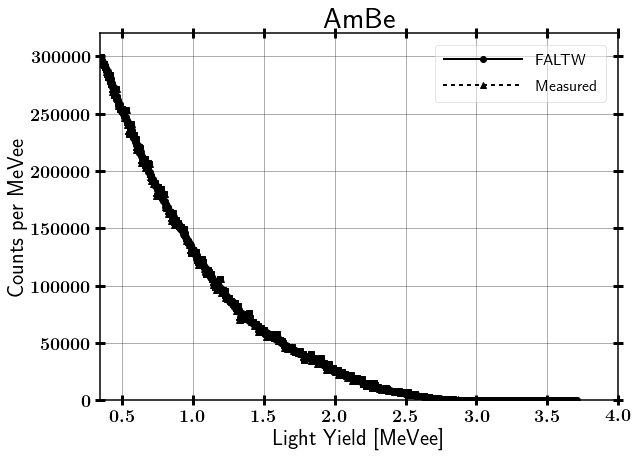

In [17]:
# Import PHS data and plot
faltwPHSData = readFlu(heprowPath+faltwPHSName, delim_whitespace=True, names=['lowE', 'absPHS', 'absSigma'],
               skiprows=3)
measPHSData = readFlu(heprowPath+measPHSName, delim_whitespace=True, names=['lowE', 'absPHS', 'absSigma'],
               skiprows=3)
faltwPHSHisto = Histogram()
faltwPHSHisto.build_histo(faltwPHSData['lowE'].tolist(), 
                         bin_differentiation(faltwPHSData['lowE'].tolist(),
                                             faltwPHSData['absPHS'].tolist()),
                       uncert=faltwPHSData['absSigma'].tolist(), edgeLoc=heprowBinBounds,
                       name='FALTW')
measPHSHisto = Histogram()
measPHSHisto.build_histo(measPHSData['lowE'].tolist(), 
                         bin_differentiation(measPHSData['lowE'].tolist(),
                                             measPHSData['absPHS'].tolist()),
                         uncert=measPHSData['absSigma'].tolist(), edgeLoc=heprowBinBounds,
                         name='Measured')
faltwPHSHisto.plot(measPHSHisto, logY=False, title='AmBe', xLabel='Light Yield [MeVee]',
                 yLabel='Counts per MeVee', yMax=320000, xMin=0.34, xMax=4.0)

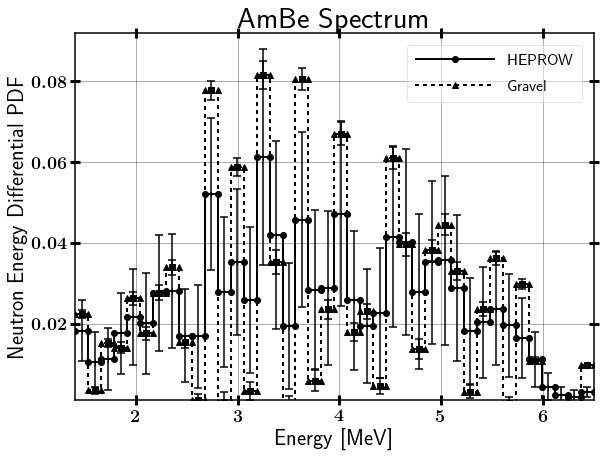

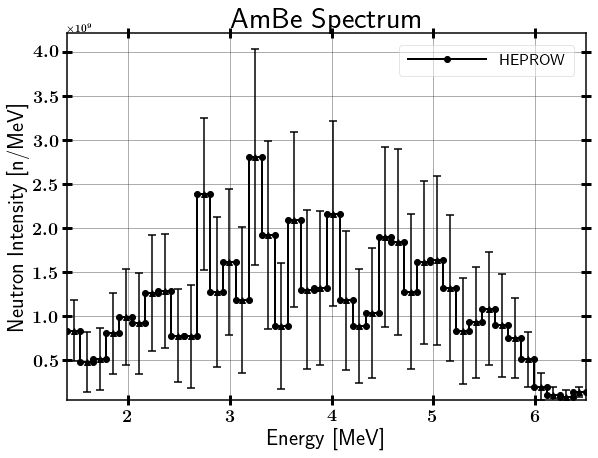

In [18]:
# Linear
heprowHisto.plot(grvHisto, title='AmBe Spectrum', xLabel='Energy [MeV]',
                 yLabel='Neutron Energy Differential PDF', savePath=outPath+'AmBe_pdf_40bins',
                 xMin=1.4, xMax=6.5)
heprowAbsHisto.plot(title='AmBe Spectrum', xLabel='Energy [MeV]', 
                    yLabel='Neutron Intensity [n/MeV]', savePath=outPath+'AmBe_abs_40bins',
                    xMin=1.4, xMax=6.5)